# HW 5
* Robert 'Quinn' Hull
* I acknowledge that this exam is solely my effort. I have done this work by myself. I have noted when and how I have used resources to help me arrive at my conclusions



In [1]:
## Modules
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.svm.libsvm import predict_proba


/Users/roberthull/opt/miniconda3/envs/Res1/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.svm.libsvm module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imported from sklearn.svm is now part of the private API.
  warnings.warn(message, FutureWarning)


## Semi - Supervised Learning
* Implement a self-training algorithm
* Resources:
    * I used this article to double check my workflow, but didn't end up using any of the code from it. I think the main functionality I learned was the sklearn predict_proba function, super helpful https://towardsdatascience.com/a-gentle-introduction-to-self-training-and-semi-supervised-learning-ceee73178b38

<img src="assets/Screen Shot 2021-04-12 at 3.47.47 PM - Self-Training Algorithm.png" width="600" />


## 1. An experiment on Synthetic Data
* Generate 2D Gaussian dataset
* Training Set: 1000 -> (500 samples from each class)
* Testing Set: 1000 -> (500 samples form each class)
* Requirements:
    * Self-Training Must Use a Classifier that can you probabilities to select the data points that will have pseudo labels
    * Choose a suitable threshold to determine the data samples that will be labeled for the next round of self-training
    * Report the error of the self-training algorithm on the testing data at:
        1. The first time a classifier is training using only labled data
        2. At least one time point during the self-training process
        3. After self-training is complete
        * Comment on the results
    * Peform an experiment reporting the above requirements with 10% and then 25% of the training data are labeled



#### Experiment Writeup
* My model uses a quadratic discriminant classifier (from the first homework).
* Some orienting notes on the figures below. The left figure shows the several percentages measuring the performance of the model at each iteration 
    * Percent Classifier Error (blue line) shows how well the quadratic discriminant classifier is performing on the unlabeled (in this case, also 'test') data. Higher values mean the classifier is mis-identifying more readily in what's left of the unlabeled dataset.
    * Percent Mislabeled Error (red line) shows the percent of the data moved from unlabeled to labeled sets that have been mislabeled. This is a cumulative function (once mislabeled, always mislabeled). Higher percentages mean  
    * Percent Samples Added to Label (green line) shows the percent of the unlabeled dataset that has been moved into the labeled dataset. This is a cumulative function (once moved, always moved). 

* After generating two gaussian datasets with overlapping distributions (see below), I started testing the model. 
    * First, I began by setting the probability threshold (required to decide whether or not to add a data point to the labeled set) at 0.9 and iterated through this process 50 times
        
        <img src="assets/QuadraticDiscriminant_10.9_new.png" width="600" />

        * This reclassified nearly half of the dataset to labeled data, but made a decent number of errors (on the order of 20)
        * This showed me that I had selected a tolerance that was too low, and probably was running for longer than necessary
    * Then, I set the probability threshold at 0.95 and decreased the number of iterations to 10

        <img src="assets/QuadraticDiscriminant_10.95.png" width="600" />

        * This reclassified roughly 40% of the dataset to labeled data, and made fewer errors (on the order of <10)
        * This showed me that increasing the tolerance was the surest way to make fewer classification errors, however it comes with the cost of reclassifying less data. 

    * To see if I could get rid of all classification errors, I set the tolerance to 0.99 (keeping the number of iterations running constant)

        <img src="assets/QuadraticDiscriminant_10.99.png" width="600" />

        * This resulted in nearly perfect classification during the relabeling process. However, only 20% of the unlabeled dataset was able to be confidently put into the labeled set

    * I then set the strictest tolerance I could think of, 0.9999. Thus the model would only reclassify when it was super sure

        <img src="assets/QuadraticDiscriminant_10.9999.png" width="600" />

        * This resulted in zero reclassification errors, however only labeled roughly 5% of the dataset. 

* My takeaways: 
    * Labeling data using this semi-supervised technique is a tradeoff between accuracy and the amount of labelling you are able to do. I.E. - setting a loose tolerance can get you to relabel most of the data, but you find more and more mislabeled datapoints creeping into your new labeled dataset. 
    * Percentages only tell part of the story. Although the percent mislabeled error can be helpful, it's really important to visualize the dataset as we have done to (hopefully) get a better idea of how the classifier has performed. 
    * Its interesting that this approach only relabels data that is relatively far from the apparent decision boundary. This makes sense (given that the model would be lesson confident in this area), but I'd like to retry this by shuffling my dataset.
    * I'd like to try this again with a different classifier sometime. I think the quadratic discriminant is probably the roughest one we can use. But it is interesting that it 
    * Really intersting (but predictable) that the percent classifier error (blue line) increases over time. This makes sense in that the classifier is only left trying to make predictions on the unlabeled part of the dataset which is hardest to understand. I.E. You've preferentially taken all the low-hanging fruit and moved it into the labeled section, and so you are left making your predictions on data that are more uncertain. The more you move to the labeled dataset, the more classification errors you will have on the remaining samples (by percentage)
        


### 2D Gaussian dataset
* Training Set: 1000 -> (500 samples from each class)
* Testing Set: 1000 -> (500 samples form each class)

In [99]:
# *NOTE What is covariance matrix, really?
def randomsamples(d, size, up=1, down=-1, u=False, sig=False, condin = True, retall = False):
    """A function to generate random samples
        inputs: 
        d -> dimensions (int)
        size -> the size of the sample desired
        up -> the max of range of numbers to generate random 
            (default 1) 
        down -> the min of range of numbers to generate random
            (default -1)
        u -> optional input mean, a vector of size d
            (if not added, script will generate randomly)
        sig -> optional input covariance matrix, a matrix 
            of dimensions d*d
            (if not added, script will generate randomly)
        condin -> conditional independence boolean
            if True (default) then off-diagonal 
            values of sigma are zero
            if False, then any values in sigma
            may be a real number
        retall -> boolean for returning u and sigma
            True -> returns distribution, u, sig
            False -> returns distribution
            (default False)
        

        returns: 
        a multivariate matrix sample with gaussian distribution    
        
        and optionally u and sig
        """

    if u is False:
        ## means of dimensions 'd' [0, 1)
        u = np.random.uniform(down, up, size=(d,))
    
    if sig is False:
        ## covariance matrix of dimension 'd*d' [0,1)
        sig = np.random.uniform(down, up, size=(d,d))
        ## test for conditional independence
        if condin:
            sig = sig*np.identity(d)

    if retall:
        return np.random.multivariate_normal(u, sig, size).T, u, sig

    else:
        return np.random.multivariate_normal(u, sig, size).T

<ipython-input-99-ce2ff57db36f>:45: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(u, sig, size).T, u, sig


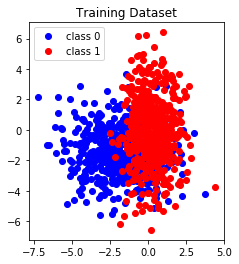

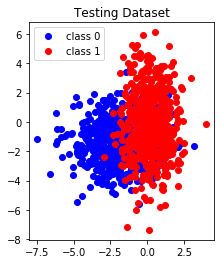

In [138]:
# 1. globals 
d = 2 # dimensions
k = 1000 # size of input
n = 500 # size of test subset
class_num = 2 # number of classes
up_in = 6 # upper bound of input data
down_in = -6 # lower bound of input data

# 2. create bivariate gaussian data with 3 known classes, that are conditionally independent! 
x_1, u_true1, sig_true1 = randomsamples(d,k,up=up_in,down=down_in,retall=True)
x_2, u_true2, sig_true2 = randomsamples(d,k,up=up_in,down=down_in,retall=True)


# 3. reserve some as a test set (n number)
x_1_train, x_1_test = x_1[:,0:-n], x_1[:,-n:]
x_2_train, x_2_test = x_2[:,0:-n], x_2[:,-n:]
x_train_list = [x_1_train, x_2_train]
x_test_list = [x_1_test, x_2_test]

# 4. calculate mean and sigma from other (train) set for each of three classes
u_1, u_2 = np.mean(x_1_train, axis=1), np.mean(x_2_train, axis=1)
sig_1, sig_2 = np.var(x_1_train, axis=1), np.var(x_2_train, axis=1)
u_list = [u_1, u_2]
sig_list = [sig_1, sig_2]

# 5. list containing priors for each class_c
# assume equal priors (because there are the same
#   numbers in each class, they have a 1/c chance
#   of occuring, 1/2)
pri_list = [(1/2), (1/2)]

# 6. plot training
# color list for graphing
color_list = ['b', 'r']
for cla in range(class_num):
    plt.plot(x_train_list[cla][0], x_train_list[cla][1], 'o', c=color_list[cla],label="class "+str(cla))

plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Training Dataset')
plt.show()

# 6. plot testing
# color list for graphing
color_list = ['b', 'r']
for cla in range(class_num):
    plt.plot(x_test_list[cla][0], x_test_list[cla][1], 'o', c=color_list[cla],label="class "+str(cla))

plt.legend()
plt.gca().set_aspect('equal')
plt.title('Testing Dataset')
plt.show()

### Algorthm

* for t in T:
    * 1. Train f on (xl, yl)
    * 2. Make predictions on Xu with f(x) x<-Xu
    * 3. Choose the samples in Xu w/ high confidence and add them into the labeled dataset xl 
        * Make it a hard label 
        * Use the posterior to make the decision

    * NOTE: Report Error 
        * The first time a classifier is trained
        * at least one point during self-training 
        * after self-training 
    


In [161]:
# original dataset
X_l = np.concatenate(x_train_list,axis=1).T # training data, predictors
y_l = np.array([np.full((k-n),0), np.full((k-n),1)]).flatten() # training data, target
X_u = np.concatenate(x_test_list,axis=1).T # testing data, predictors - in this case unlabeled data
y_u = np.array([np.full((n),0), np.full((n),1)]).flatten() # testing data, target - in this case treated as unlabeled data
y_real = y_l # for comparing after the fact to the labels added

# create classifier
clf = QuadraticDiscriminantAnalysis()

# name
name = 'QuadraticDiscriminant_1'

# set run time
T = 10

# set posterior probability threshold for appending predicted unlabeled data into labeled dataset
th = 0.9999

# keep track of loss and num unlabeled
loss = [0] # prediction error (regardless of whether or not unlabeled data are added)
num = [1] # the number of samples that have been added to the newest dataset
hcloss = [0] # the number of high-confidence mistakes added to labeled data



In [162]:
# algorithm
for t in range(T):
    # print('iteration', t)
    # 1 . Train f on (xl, yl)
    clf.fit(X_l, y_l)

    # 2. Make predictions on Xu with f(x) x<-Xu
    y_hat = clf.predict(X_u)

    # 3. Choose the samples in Xu w/ high confidence and add them into the labeled dataset xl 
    # predict probabilities for each prediction
    X_u_prob = clf.predict_proba(X_u)
    # find indices of those that make threshold
    idx = np.where(X_u_prob >= th)
    # print('number of high probability ids', len(idx[0]))
    in_arr, in_y = np.array(X_u[idx[0]]), idx[1] # for later use adding and deleting x and y data
    y_real = np.append(y_real, y_u[idx[0]]) # to remember the true values for everything in y_label

    # report prediction error (regardless of whether or not unlabeled data are added)
    totalwrong = len(np.where(y_hat != y_u)[0])
    total = y_u.shape[0]
    err = (totalwrong / total)
    loss.append(err)

    # add x data, and y data to labeled
    X_l, y_l = np.vstack([X_l, in_arr]), np.append(y_l, in_y)
    # print('shapes of new labeled sets x and y', X_l.shape, y_l.shape)

    # remove x data, and y data from unlabeled
    X_u, y_u = np.delete(X_u,idx[0],axis=0), np.delete(y_u,idx[0])
    # print('shapes of new unlabeled sets x and y', X_u.shape, y_u.shape, '\n')

    # the number of new samples added
    num.append(y_u.shape[0]/k)

    # the number of samples added from the wrong class to the labeled data
    labeledwrong = len(np.where(y_l != y_real)[0])
    totallabeled = y_l.shape[0] - n*2
    hcloss.append(labeledwrong / totallabeled)



<ipython-input-163-3d805ab23129>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


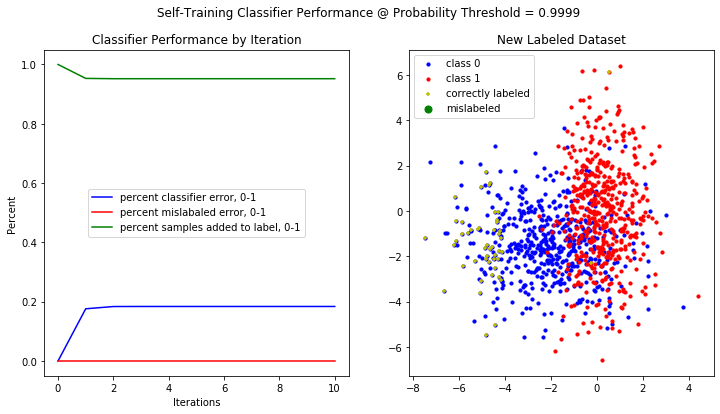

In [163]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
# ax2 = ax.twinx()
ax[0].plot(loss, label='percent classifier error, 0-1', c='b')
ax[0].plot(hcloss, label='percent mislabaled error, 0-1', c='r')
ax[0].plot(num, label='percent samples added to label, 0-1', c='g')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Percent')
ax[0].legend(loc='center')
ax[0].set_title('Classifier Performance by Iteration')

ax[1].scatter(X_l[:,0][y_l == 0],X_l[:,1][y_l == 0], label='class 0', s=10, c='b')
ax[1].scatter(X_l[:,0][y_l == 1],X_l[:,1][y_l == 1], label='class 1', s=10, c='r')
ax[1].scatter(X_l[n*2-1:-1,0][y_l[n*2-1:-1] == y_real[n*2-1:-1]],X_l[n*2-1:-1,1][y_l[n*2-1:-1] == y_real[n*2-1:-1]], label='correctly labeled', s=10, marker='+', c='y')
ax[1].scatter(X_l[:,0][y_l != y_real],X_l[:,1][y_l != y_real], label='mislabeled', s=50, marker='o', c='g')
ax[1].legend()
ax[1].set_title('New Labeled Dataset')
fig.suptitle('Self-Training Classifier Performance @ Probability Threshold = '+str(th))
fig.show()
plt.savefig('assets/'+name+str(th)+'.png')




## 2. An Experiment on Real World Data
* Implement the self-training algorithm using ten datasets available on the course Github repo 
* Requirements:
    * Report your results using 5-fold cross validation. 
        * In each cross-validation step you can use only 15% of data as labeled
* Write a brief discussion on whether semi-supervised helped on real-world data sets